# 0.0 - Imports

In [121]:
# Bibliotecas
import pandas     as pd
import numpy      as np
import inflection
import seaborn    as sns

from IPython.display     import HTML

from matplotlib          import pyplot as plt

from plotly              import express

from sklearn             import cluster
from sklearn             import metrics

from yellowbrick.cluster import KElbowVisualizer

## 0.1 - Helper Functions

In [122]:
snakecase = lambda x: inflection.underscore(x)

# Configurações de Layout
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = (24,9)
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:90% ! important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 - Carregamento dos dados

In [123]:
# Carregar os dados para análise.
df = pd.read_csv('../data/raw/Ecommerce.csv', encoding = 'unicode_escape').drop(columns=['Unnamed: 8'])

# 1.0 - Descrição dos Dados

In [132]:
df1 = df.copy()

## 1.1 - Atributos

**InvoiceNo:** Número que identifica a transação da compra.

**StockCode:** Código do produto.

**Description:** Descrição do produto.

**Quantify:** Quantidade comprada do produto.

**InvoiceDate:** Data em que a transação foi efetuada.

**UnitPrice:** Preço unitário do produto comprado.

**CustomerID:** Número que identifica o cliente.

**Country:** País em que o cliente realizou a transação.

## 1.2 - Dimensão dos Dados

In [133]:
rows = df1.shape[0]
columns = df1.shape[1]

print(f'Número de Linhas: {rows}.')
print(f'Número de Colunas: {columns}')

Número de Linhas: 541909.
Número de Colunas: 8


## 1.3 - Renomear Nome das Colunas

In [134]:
# Renomear Lista
lista = df1.columns.tolist()

# Nome das novas colunas
new_columns = [snakecase(x) for x in lista]

# renomear as colunas
df1.columns = new_columns

## 1.4 - Check NA

In [135]:
# Verificação e existem dados nulos
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [136]:
# Dropagem das linhas que possuem NA
df1 = df1.dropna()

# Verificação
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 - Natureza das Variáveis

In [137]:
# Verificando a tipagem dos dados.
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.6 - Limpeza dos Dados

In [138]:
# Nome dos produtos em tamanho minúsculo.
df1['description'] = df1['description'].apply(lambda x: x.lower())

# Nome dos paíse em tamanho minúsculo.
df1['country'] = df1['country'].apply(lambda x: x.lower())

## 1.7 - Mudança de Variáveis

In [139]:
# Mudança de tipagem do invoice_date
df1['invoice_date'] = df1['invoice_date'].apply(lambda x: pd.to_datetime(x))

# customer_id
df1['customer_id'] = df1['customer_id'].apply(lambda x: str(int(x)))

## 1.8 - Estatística Descritiva 

# 2.0 - Feature Engineering

In [143]:
df2 = df1.copy()

## 2.1 - Criação das Features para o Modelo RFM

In [144]:
# ----------------- Construção do DataFrame do Modelo RFM -------------------------

# Dataframe Referência
df_ref = df2.drop(['invoice_no', 'stock_code', 
                   'description', 'quantity', 
                   'invoice_date','unit_price', 'country'], axis=1).copy()

# Remover duplicidades 
df_ref = df_ref.drop_duplicates().reset_index(drop=True)

# ------ Construção da Feature Recency ---------

df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df_recency['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy() 

# Merge do df_recency com o dataframe referência.
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# ------ Construção da Feature Frequencily -------

df_frequencily = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_frequencily = df_frequencily.rename(columns={'invoice_no' : 'frequencily'})

# Merge do df_frequencily com o dataframe referência.
df_ref = pd.merge(df_ref, df_frequencily, on='customer_id', how='left')

# ------ Construção da Feature Monetary -------

df2['total_by_product'] = df2['quantity'] * df2['unit_price']

df_monetary = df2[['customer_id', 'total_by_product']].groupby('customer_id').sum().reset_index()
df_monetary = df_monetary.rename(columns = {'total_by_product' : 'gross_revenue'})

# Merge do df_monetary com o dataframe referência.
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# 3.0 - Hiperparameter FineTunning

In [150]:
df7 = df6.copy()

In [151]:
# Ajuste dos Dados os modelos
df_treino = df_ref.drop(columns=['customer_id'])

# quantidade de cluster
clusters = [2, 3, 4, 5, 6]

## 3.1 - Within-Cluster Sum of Square (WSS)

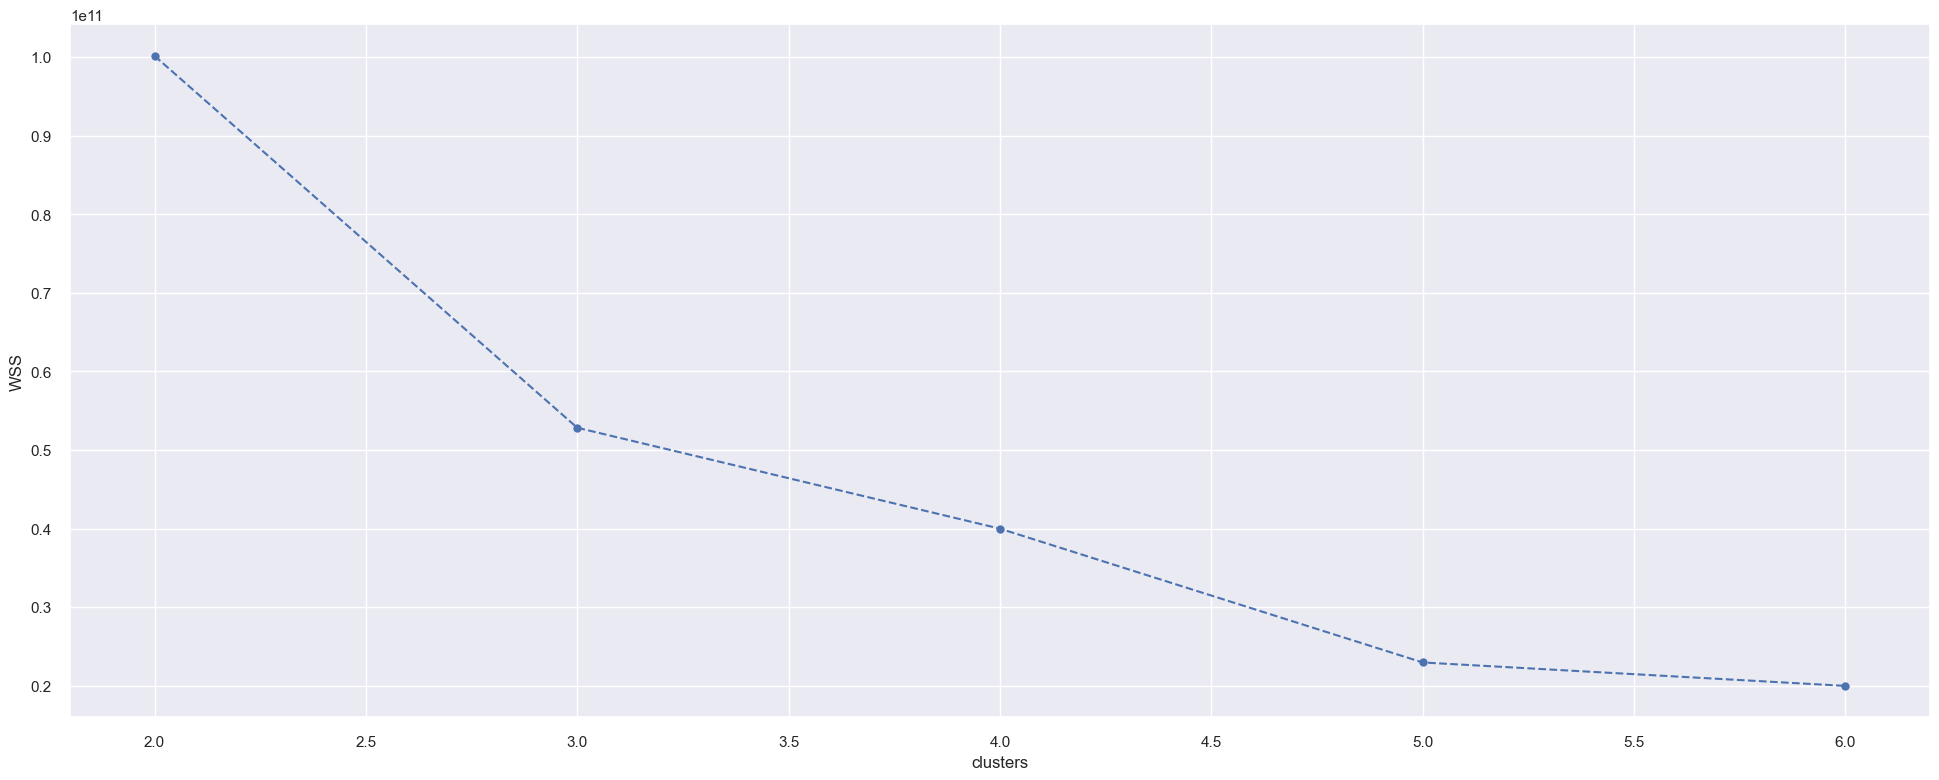

In [152]:
wss = []

for k in clusters:
    
    # model definition
    kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # model training
    kmeans.fit(df_treino)
    
    # validation
    wss.append(kmeans.inertia_)
    
# Plotagem do WSS
plt.plot(clusters, wss, linestyle='--', marker='o', color='b');
plt.xlabel('clusters');
plt.ylabel('WSS');

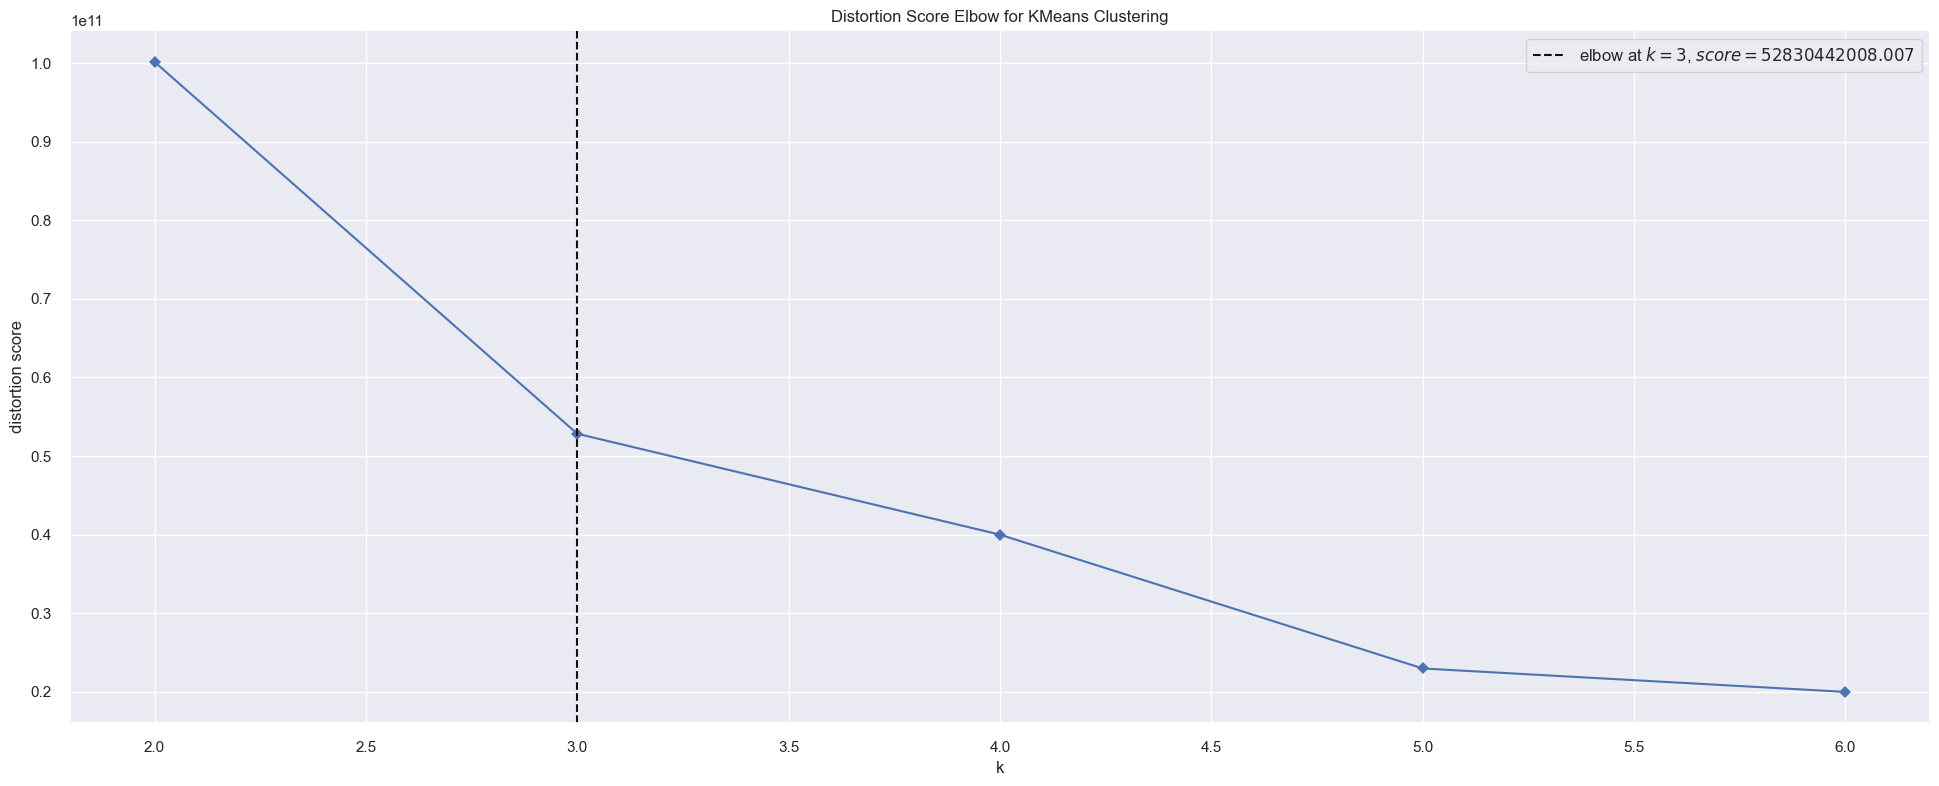

In [154]:
# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_wss = KElbowVisualizer(kmeans, k=clusters, timings=False)
graph_wss.fit(df_treino)
graph_wss.show();

## 3.2 Silhouette Score

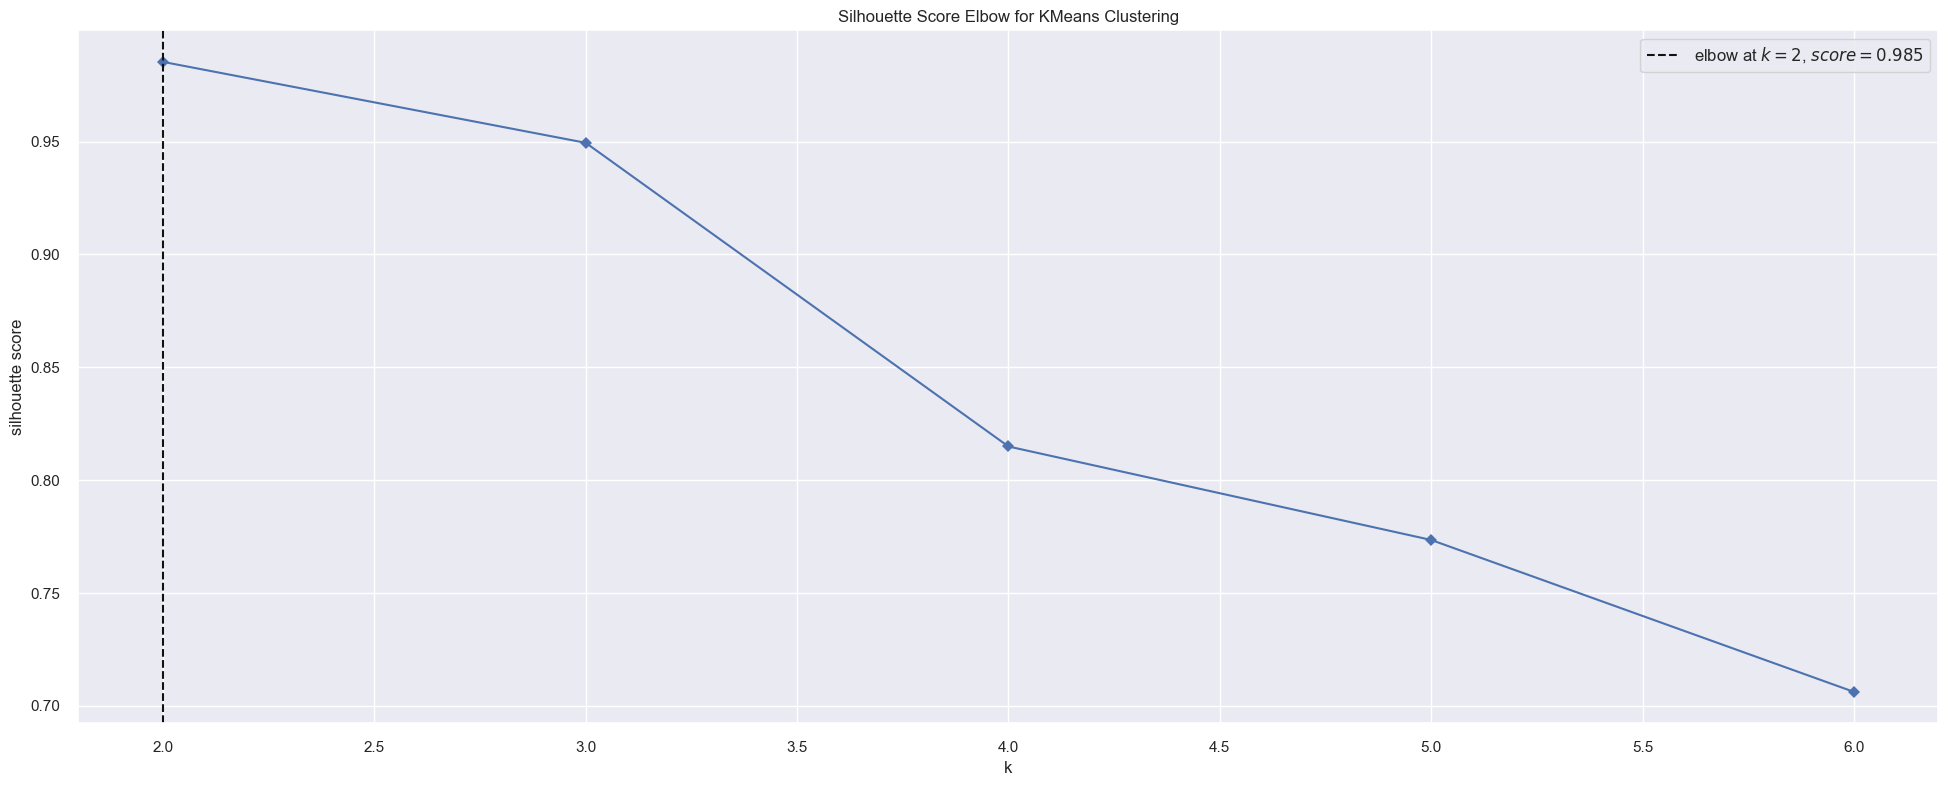

In [155]:
# Usando o pacote yellowbrick para nos ajudar a determinar o melhor k de cluster.
graph_silhoutte = KElbowVisualizer(kmeans, k=clusters, metric='silhouette', timings=False)
graph_silhoutte.fit(df_treino)
graph_silhoutte.show();

# 4.0 - Model Training

## 4.1 - K-means

In [156]:
# Modelo definido
k=3
kmeans = cluster.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treino do Modelo
kmeans.fit(df_treino)

# clustering
labels = kmeans.labels_

### 4.1.2 - K-means CrossValidation

In [157]:
# WSS Score
print(f'WSS Score: {kmeans.inertia_}.')

# Silhouette Score
print(f'Silhouette Score: {metrics.silhouette_score(df_treino, labels)}')

WSS Score: 52830442008.00697.
Silhouette Score: 0.9494677566681542


# 5.0 - Cluster Analysis

In [158]:
df9 = df_treino.copy()

## 5.1 - Inspeção por Visualização

In [159]:
# Rotulando cada cliente de acordo o o seu cluster
df9['cluster'] = labels

# Preparação para a plotagem do gráfico
visualizacao = express.scatter_3d(df9, x='recency_days', y='frequencily', z='gross_revenue', color='cluster')
visualizacao.show()

## 9.2 - Perfil dos Cluster

In [184]:
# rotular cada cliente de acordo com o seu cluster
df_ref['cluster'] = labels

# quantidade de clientes por cluster
df_cluster = df_ref[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id':'number_customers'})

# Media de Faturamento por Cluster
df_mean_gross_revenue = df_ref[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index().rename(columns= {'gross_revenue':'mean_gross_revenue'})

# Media de Frequência de Compras
df_mean_frequencily= df_ref[['frequencily', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'frequencily':'mean_frequencily'})

# Media de Recências
df_mean_recency_days= df_ref[['recency_days', 'cluster']].groupby('cluster').mean().reset_index().rename(columns={'recency_days':'mean_recency_days'})

# Junção de todos os dados em uma única tabela.
df_aux = pd.merge(df_cluster, df_mean_recency_days, how='inner', on='cluster')
df_aux = pd.merge(df_aux, df_mean_frequencily, how='inner', on='cluster')
tabela_final = pd.merge(df_aux, df_mean_gross_revenue, how='inner', on='cluster')

# Criação da coluna que nos dá o percentual de clientes em cada cluster.
tabela_final['number_customer_percentual'] = round((tabela_final['number_customers']/tabela_final['number_customers'].sum())*100, 2)

 
# -------------------------------    Reajustes da tabela_final ----------------------------------

# reajuste recência
tabela_final['mean_recency_days'] = tabela_final['mean_recency_days'].apply(lambda x: int(x))

# reajuste ferquencia
tabela_final['mean_frequencily'] = tabela_final['mean_frequencily'].apply(lambda x: int(x))

# reajuste faturamento
tabela_final['mean_gross_revenue'] = tabela_final['mean_gross_revenue'].apply(lambda x: round(x, 2))

## Cluster 0

In [186]:
print(f'Número Clientes: {tabela_final.loc[0, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[0, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[0, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[0, "mean_gross_revenue"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[0, "number_customer_percentual"]}%.')

Número Clientes: 4335.
Média de Recência: 92 dias.
Média de Frequência: 4.
Média de Faturamento: US$ 1372.58.
Número de clientes em percentual: 99.15%.


## Cluster 1

In [187]:
print(f'Número Clientes: {tabela_final.loc[1, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[1, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[1, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[1, "mean_gross_revenue"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[1, "number_customer_percentual"]}%.')

Número Clientes: 6.
Média de Recência: 7 dias.
Média de Frequência: 89.
Média de Faturamento: US$ 182181.98.
Número de clientes em percentual: 0.14%.


## Cluster 2

In [188]:
print(f'Número Clientes: {tabela_final.loc[2, "number_customers"]}.')
print(f'Média de Recência: {tabela_final.loc[2, "mean_recency_days"]} dias.')
print(f'Média de Frequência: {tabela_final.loc[2, "mean_frequencily"]}.')
print(f'Média de Faturamento: US$ {tabela_final.loc[2, "mean_gross_revenue"]}.')
print(f'Número de clientes em percentual: {tabela_final.loc[2, "number_customer_percentual"]}%.')

Número Clientes: 31.
Média de Recência: 13 dias.
Média de Frequência: 53.
Média de Faturamento: US$ 40543.52.
Número de clientes em percentual: 0.71%.


## Tabela

In [190]:
tabela_final

,cluster,number_customers,mean_recency_days,mean_frequencily,mean_gross_revenue,number_customer_percentual
0,0,4335,92,4,1372.58,99.15
1,1,6,7,89,182181.98,0.14
2,2,31,13,53,40543.52,0.71
